In [96]:
%matplotlib inline

from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap


import matplotlib.pyplot as plt
import numpy as np

X, y = make_blobs(n_samples=100, random_state=1)



$$\text{Euclidean metric metric}$$

In [84]:
def e_metrics(x, y):    
    return np.sqrt(np.sum(np.square(x-y)))

$$\text{KNN}$$

In [87]:
class KNN():
    def __init__(self, k = 1, w_type = 'distance', w_name = 'inverse', weighted = False):
        self.k = k
        self.weighted = weighted
        self.w_type = w_type
        self.w_name = w_name
        
    def fit_predict(self, X_train, X_test, y_train):
        answers = np.zeros(X_test.shape[0])
        labels = set(y_train)
        
        for i, x in enumerate(X_test):
            
            test_distances = np.zeros(X_train.shape[0], dtype='object')
            
            for j in range(X_train.shape[0]):
                
                distance = e_metrics(x, X_train[j])
                test_distances[j] = (distance, y_train[j])
                
            classes = {class_label: 0 for class_label in labels}
            neighbours = self.find_neighbours(test_distances)
            if self.weighted:
                weights = self.find_weights(neighbours)                
            else:
                weights = np.ones(len(neighbours))
            for neighbour, w in zip(neighbours, weights):
                    classes[neighbour[1]] += w
 
            answers[i] = sorted(classes, key=classes.get)[-1]
        return answers                
            
    def find_neighbours(self, distances):
        """
        distanaces - list of tuples: [(dist, label), ...]
        """
        z = 0
        for i in range(self.k):
            for j in range(len(distances)-1-z):
                if distances[j][0] < distances[j+1][0]:
                    distances[j], distances[j+1] = distances[j+1], distances[j]
            z += 1
        return distances[-self.k::][::-1]
    
    def find_weights(self, neighbours):
        """
        distances - list of tuples: [(dist, label), ...]
        """
        weights = np.zeros(self.k)
        if self.w_type == 'distance':
            if self.w_name == 'inverse':                
                eps = 1e-15
                for i, neighbour in enumerate(neighbours):
                    weights[i] = 1/(neighbour[0]+eps)
            elif self.w_name == 'geom':
                q = 0.5
                for i, neighbour in enumerate(neighbours):
                    weights[i] = q**neighbour[0]
                
        elif self.w_type == 'ordinal':
            if self.w_name == 'geom':
                q = 0.5
                for i in range(self.k):
                    weights[i] = q**(i+1)
                
            elif self.w_name == 'pos':
                for i in range(self.k):
                    weights[i] = 1/(i+1)           
        return weights

$$\text{Accuracy}$$

In [88]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

$$\text{Get Graph}$$

In [89]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчёт пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = KNN(k=k).fit_predict(X_train, np.c_[xx.ravel(), yy.ravel()], y_train)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

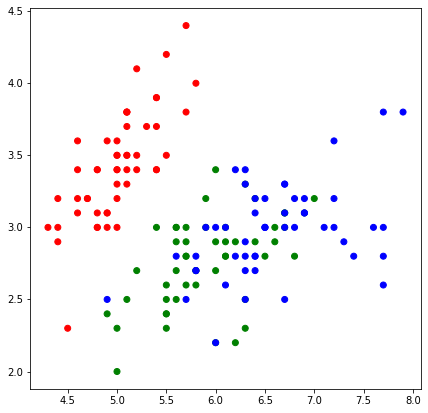

In [179]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]


X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

### <b> Task №1

In [91]:
w_types = [('distance', 'inverse'), ('distance', 'geom'),
           ('ordinal', 'geom'), ('ordinal', 'pos')]
ks = np.arange(1, 100, 2)

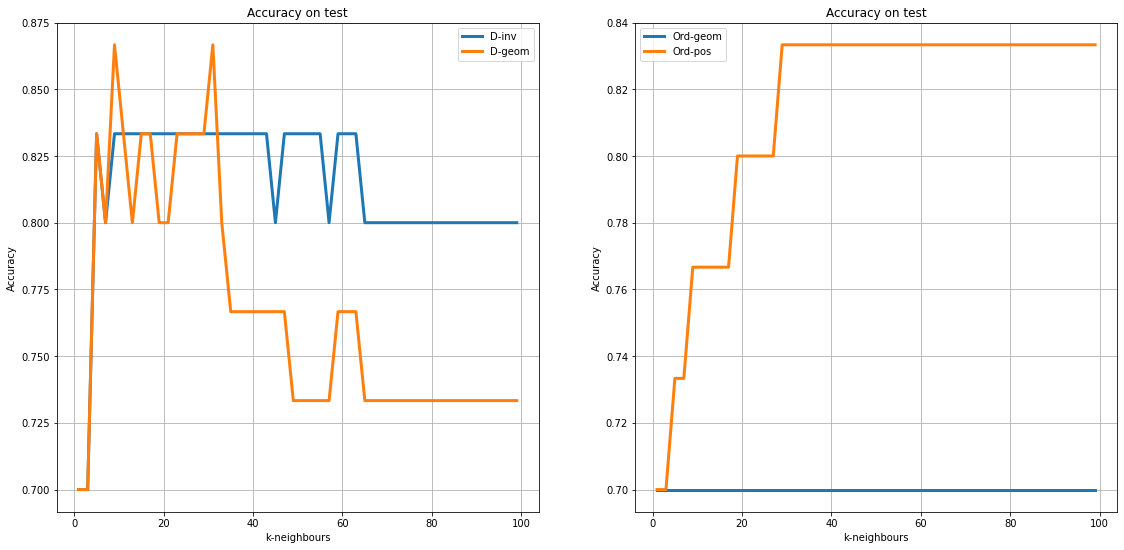

In [92]:
lst = []
for k in ks:    
    A_list = []
    for w_type, w_name in w_types:
        knn_clf = KNN(k, w_type, w_name, weighted = True)
        y_pred = knn_clf.fit_predict(X_train, X_test, y_train)
        A_list.append(accuracy(y_pred, y_test))
    knn_clf = KNN(k)
    y_pred = knn_clf.fit_predict(X_train, X_test, y_train)
    A_list.append(accuracy(y_pred, y_test))
    lst.append(A_list)
                         
    #print(f'k = {k}. D-inv: {A_list[0]:.2f}\t D-geom: {A_list[1]:.2f}\t Ord-geom: {A_list[2]:.2f}\t Ord-pos: {A_list[3]:.2f}\t Non-weight: {A_list[4]:.2f}')
    
Z = list(zip(*lst))
distance_weights_accuracy = Z[:2]
ordinal_weights_accuracy = Z[2:-1]
non_weigts_accuracy = Z[-1]

fig, ax = plt.subplots(1, 2, figsize=(19, 9))
for x in distance_weights_accuracy:
    ax[0].plot(ks, x, linewidth=3)
#ax[0].plot(ks, non_weigts_accuracy, linewidth=3)
ax[0].set_xlabel('k-neighbours')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy on test')
ax[0].legend(['D-inv', 'D-geom'])
ax[0].grid()

for x in ordinal_weights_accuracy:
    ax[1].plot(ks, x, linewidth=3)
#ax[1].plot(ks, non_weigts_accuracy, linewidth=3)
ax[1].set_xlabel('k-neighbours')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy on test')
ax[1].legend(['Ord-geom', 'Ord-pos'])
ax[1].grid()

* "Взвешивание соседей" по расстоянию хоть и логичная идея, но крайне нестабильная в отличии от "взвешивания" на основе порядкого номера соседа. Наверное, чтобы использовать взвешивание на основе расстояний необходимо знать геометрию пространства объектов и производить взвешивание не от суммарного расстояния до объекта, а изначально искать расстояние как сумму взвешенных расстояний. 
* Способ взвешивания, определеяемый как: $$w(i) = \frac{1}{i}$$ оказался наиболее устойчивым для этих данных. Это можно увидеть на графике ниже. (label = 'Ord-pos')

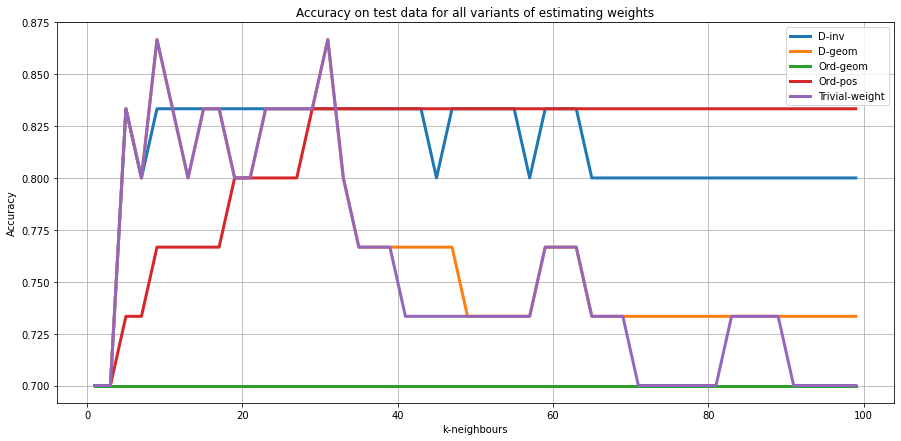

In [95]:
plt.figure(figsize = (15, 7))

for x in Z:
    plt.plot(ks, x, linewidth = 3)
    
plt.xlabel('k-neighbours')
plt.ylabel('Accuracy')
plt.title('Accuracy on test data for all variants of estimating weights')
plt.legend(['D-inv', 'D-geom', 'Ord-geom', 'Ord-pos', 'Trivial-weight'])
plt.grid()
plt.show()

### <b> Task №2

In [157]:
X, y = make_blobs(n_samples=100, random_state=3)

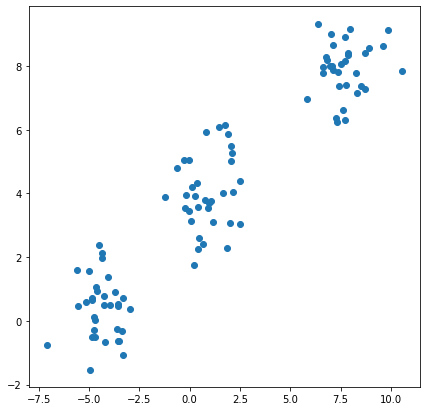

In [158]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

$$\text{K-means}$$

In [146]:
class Kmeans():
    def __init__(self, k=1, max_iter=100, min_dist=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.min_dist = min_dist
    
    def score(self, classes, centroids):
        score = 0
        for i in range(self.k):
            distances = np.array([e_metrics(centroids[i], x)**2 for x in classes[i]])
            score += np.mean(distances)
        return score
            
            
    
    def fit_predict(self, data):
        self.score_list = []
        centroids = np.array([data[i] for i in range(self.k)])
        
        for _ in range(self.max_iter):
            classes = {i: [] for i in range(self.k)}
            
            for x in data:
                distances = [e_metrics(x, centroid) for centroid in centroids]
                
                x_class = distances.index(min(distances))
                
                classes[x_class].append(x)
            
            self.score_list.append(self.score(classes, centroids))
            old_centroids = centroids.copy()
            
            for label in classes:
                centroids[label] = np.average(classes[label], axis = 0)
                
            optimal = True
            
            for centroid in range(len(centroids)):
                if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                    optimal = False        
            if optimal:
                break
            
        return old_centroids, classes      

$$\text{Plot clusters}$$

In [138]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесём на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесём объекты, раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

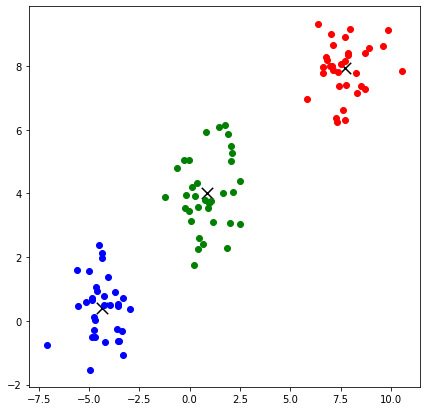

In [160]:
# определим максимальное количество итераций
max_iterations = 3

# и минимальное расстояние между центроидами до пересчёта и после него, при котором нужно остановить алгоритм
min_distance = 1e-7

# сразу определим известное нам количество кластеров
k = 3

clf_kmeans = Kmeans(k, max_iterations, min_distance)

centroids, clusters = clf_kmeans.fit_predict(X)

visualize(centroids, clusters)

* Посторим графики сначала для первых 5-и значений количества кластеров. 

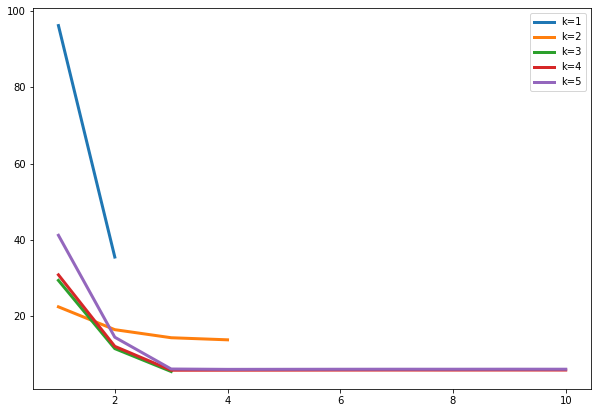

In [170]:
max_iterations = 50
min_distance = 1e-3

n_clusters = np.arange(1, 11)

fig, ax = plt.subplots(1, figsize = (10, 7))

for k in n_clusters[:5]:
    clf_kmeans = Kmeans(k, max_iterations, min_distance)
    centroids, clusters = clf_kmeans.fit_predict(X)
    ax.plot(np.arange(1, len(clf_kmeans.score_list) +1), clf_kmeans.score_list, linewidth = 3, label = f'k={k}')
ax.legend()
plt.show()

* Значения <b>k</b> = [1, 2] можно исключить. Рассмотрим внимательнее поведение при <b>k</b>=[3,4,5]

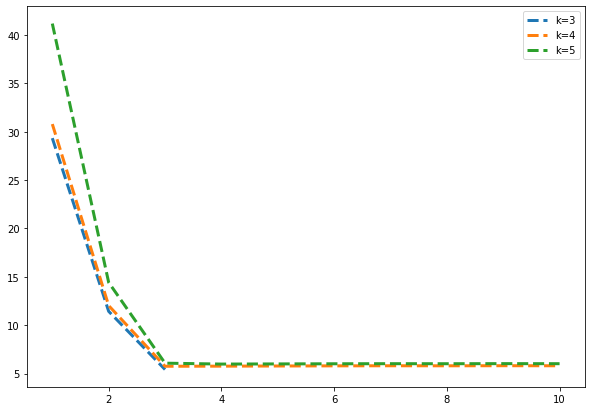

In [175]:
max_iterations = 50
min_distance = 1e-3

n_clusters = np.arange(1, 11)

fig, ax = plt.subplots(1, figsize = (10, 7))

for k in n_clusters[2:5]:
    clf_kmeans = Kmeans(k, max_iterations, min_distance)
    centroids, clusters = clf_kmeans.fit_predict(X)
    ax.plot(np.arange(1, len(clf_kmeans.score_list) +1), clf_kmeans.score_list, linewidth = 3, label = f'k={k}', linestyle='dashed')
ax.legend()
plt.show()

* Посторим графики для оставшихся значений количества кластеров. 

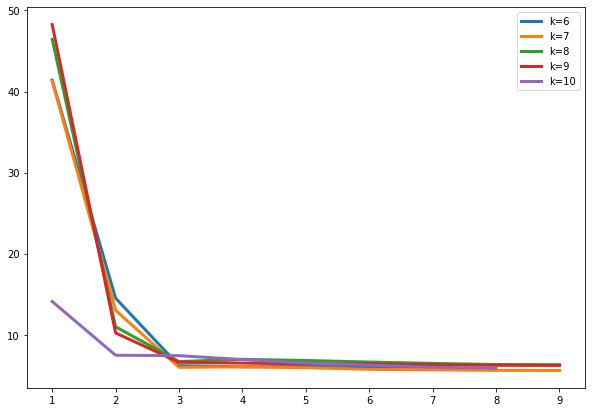

In [176]:
max_iterations = 50
min_distance = 1e-3

n_clusters = np.arange(1, 11)

fig, ax = plt.subplots(1, figsize = (10, 7))

for k in n_clusters[5:]:
    clf_kmeans = Kmeans(k, max_iterations, min_distance)
    centroids, clusters = clf_kmeans.fit_predict(X)
    ax.plot(np.arange(1, len(clf_kmeans.score_list) +1), clf_kmeans.score_list, linewidth = 3, label = f'k={k}')
ax.legend()
plt.show()

* <b>k</b> = 10 можно исключить. 

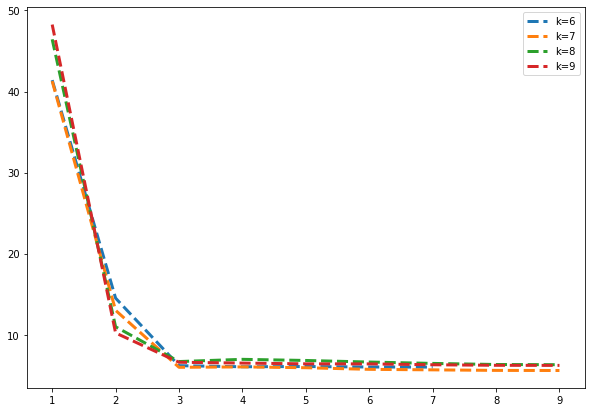

In [178]:
max_iterations = 50
min_distance = 1e-3

n_clusters = np.arange(1, 11)

fig, ax = plt.subplots(1, figsize = (10, 7))

for k in n_clusters[5:-1]:
    clf_kmeans = Kmeans(k, max_iterations, min_distance)
    centroids, clusters = clf_kmeans.fit_predict(X)
    ax.plot(np.arange(1, len(clf_kmeans.score_list) +1), clf_kmeans.score_list, linewidth = 3, label = f'k={k}', linestyle='dashed')
ax.legend()
plt.show()

* По методу "локтя" можно заключить, что <b>k</b> = 3 — оптимальное значение для этих данных.